In [1]:
import os
from datetime import datetime, timedelta
from typing import Tuple, Union, Literal, Optional
import numpy as np
import pandas as pd
import pytz
from scipy import signal
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import kaiserord, lfilter, firwin, freqz
import scipy.fftpack as fftp
import pycwt
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib.axes import Axes as mpl_axes
from matplotlib.colors import Colormap
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter
from ground_truth_annotations import annotate_gt

Using a DPI around 100 for the notebook (should be fine for most screens, adjust as needed). High-DPI option is for final proofing.

In [2]:
NOTEBOOK_MODE_DRAFT = True # for figure DPI and save directory

A number of convenience functions for plotting

In [3]:
def plot_wavelet(time: pd.Series, signal: pd.Series, scales: np.ndarray=np.arange(1, 512), *, 
                 morlet_scale: float=6.,
                 cmap: Union[str, Colormap]='coolwarm',
                 title: Optional[str]=None,
                 ylabel: str='Period, hours',
                 xlabel: str='Time',
                 normalization: Literal['scales', 'sum']='sum',
                 contourlevels: np.ndarray=np.arange(-40, -20),
                 fixed_ylim: Optional[Tuple]=None) -> mpl_axes:
    """
    :param time: time x-axis, must have uniformly distributed values
    :param signal: y-values
    :param scales: range of scales for wavelet calculation, in x-axis sampling periods. Plotting is controlled
    separately by fixed_ylim.
    :param morlet_scale: Morlet mother wavelet scale parameter
    :param cmap: matplotlib colormap to use
    :param title: plot title
    :param ylabel: plot y-axis label
    :param xlabel: plot x-axis label
    :param normalization: normalization option, either within the same time scale ('scales') or global ('sum')
    :param contourlevels: colorbar range
    :param fixed_ylim: optional value to set the range of y-axis (periods) on the spectrogram
    :return: matplotlib axes for the generated plot
    """
    dt = time[1] - time[0]
    freqs = 1 / (pycwt.Morlet(morlet_scale).flambda() * scales)
    # We only need the power spectrum and the cone of influence
    coefs, scales, _, coi, *_ = pycwt.cwt(signal.values, dt, pycwt.Morlet(morlet_scale), freqs=freqs)
    power = (abs(coefs)) ** 2
    period = 1. / freqs
    if normalization == 'scales':
        power /= scales[:, None]
    else:
        power /= np.sum(power)
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both', cmap=cmap)
    if title is None:
        title = f'{signal.name} scaleogram'
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    day = 24 / dt
    ax.plot(time, [np.log2(day)]*len(time), 'k-')
    ax.plot(time, [np.log2(7 * day)] * len(time), 'k-')
    ax.plot(time, [np.log2(28 * day)] * len(time), 'k-')
    ax.plot(time, np.log2(coi), '0.8', lw=4)
    ax.plot(time, np.log2(coi), 'w--', lw=3)

    yticks = 2 ** np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()

    cbar_ax = fig.add_axes([0.92, 0.45, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    ax.set_xticklabels(ax.get_xticks())
    xticks = ax.get_xticklabels()
    # print([v.get_text() for v in xticks])
    newticks = [signal.index[0] + timedelta(hours=float(tickv.get_text())) for tickv in xticks if tickv.get_text()]
    ax.set_xticklabels([f'{tick:%d.%m.%Y}' for tick in newticks])
    if fixed_ylim is None:
        ax.set_ylim(9, 3)
    else:
        ax.set_ylim(fixed_ylim)
    return ax
    

def plot_season(series: pd.Series) -> None:
    """ Plots timeseries data over a single winter season
    :param series: pandas Series with timedata index
    :return: None
    """
    offset_index = series.index - pd.Timedelta(days=365 * (series.index[-1].year - 1970))
    plt.plot(offset_index, series.values, label=f'{series.index[-1].year - 1}-{series.index[-1].year}')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %-d'))

    
def single_freq_wavelet(signal: pd.Series, n_periods: int, dt: float) -> pd.Series:
    """ Calculate a wavelet transform for a single time period value
    :param signal: signal to be transformed
    :param n_periods: number of periods for transform
    :param dt: sampling frequency (delta t between samples in the signal)
    :return: pandas series containing Morlet wavelet transform of a signal
    """
    # An extremely wonky way to calculate a single curve
    freqs = np.array([1 / (pycwt.Morlet(6.).flambda() * n_periods)])
    coefficients, scales, *_ = pycwt.cwt(signal.values, dt, pycwt.Morlet(6.), freqs=freqs)
    power = (abs(coefficients)) ** 2
    #     power /= np.sum(power)
    power /= scales[:, None]
    return power[0]


def plot_corrmatr(df: pd.DataFrame, *, title: str='', cmap: Union[str,Colormap]='BrBG') -> None:
    """ A convenience wrapper over seaborn to plot correlation matrices
    :param df: pandas dataframe to calculate correlations for
    :param title: plot title
    :param cmap: plot colormap (matplotlib)
    :return: None
    """
    corrmatr = df.corr()
    sns.set_context('paper', font_scale=1.)
    sns.heatmap(corrmatr, xticklabels=corrmatr.columns, yticklabels=corrmatr.columns, 
                fmt='.2f', cmap=cmap, center=0, annot=True)
    # Decorations
    plt.title(title, fontsize=16)
    plt.xticks(fontsize=10)
    # plt.xticks(rotation=30)
    plt.yticks(fontsize=10)
    

def lowpass_filter(x: pd.Series, cutoff_steps: float) -> Tuple[pd.Series, np.ndarray]:
    """ Lowpass filtration of a singal using a finite impulse response (FIR) filter 
    :param x: pandas time series
    :param cutoff_steps: number of steps (in units of the signal sampling period) for the frequency cutoff
    :return: lowpass-filtered signal, filter response
    """
    nsamples = x.size
    nyq_rate = 0.5
    width = 1 / nyq_rate / cutoff_steps
    ripple_db = 42.0
    N, beta = kaiserord(ripple_db, width)
    taps = firwin(N, 1./cutoff_steps, window=('kaiser', beta))
    filtered_x = lfilter(taps, 1.0, x.values)
    return pd.Series(filtered_x[N-1:], index=df.index[N-1:] - pd.Timedelta(hours=(N-1)//2)), taps

Data import. A subset of the data is available alongside this code on Github.

In [4]:
df = pd.read_csv('merged-insol-fixed.csv', sep=';', parse_dates=[0], index_col=0)
retained = ['temp. C', 'Humidity %', 'UV level, W/m2', 'Insolation, kW/m2', 'Fv/Fm', 'Fo', 'Fm', 'DIo/RC', 
            'fMaxDark', 'PI', 'PSIo', 'Sm', 'VI', 'VK', 'Area']
ds = df[retained]
dt = df['t-t0, hr'][1] - df['t-t0, hr'][0]
ds.fillna({'Insolation, kW/m2': 0}, inplace=True)

/usr/lib64/python3.10/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


First, lowpass filtration, we will examine it later in more detail.

In [5]:
df_3h_filtered = pd.DataFrame()
df_1w_filtered = pd.DataFrame()
for c in ds.columns:
    df_3h_filtered[c], _ = lowpass_filter(ds[c], 3.)
    df_1w_filtered[c], _ = lowpass_filter(ds[c], 168.) # 168 hours = 1 week

In [9]:
# Probably an issue with imports, have to re-run this cell after plotting once
if NOTEBOOK_MODE_DRAFT:
    plt.rcParams['figure.dpi'] = 100
    # The following doesn't work, unfortunately
    # plt.rcParams['savefig.directory'] = os.path.join(os.getcwd(), 'draft')
    savepath = os.path.join(os.getcwd(), 'draft')
else:
    plt.rcParams['figure.dpi'] = 1200
#     plt.rcParams['savefig.directory'] = os.path.join(os.getcwd(), 'final')
    savepath = os.path.join(os.getcwd(), 'final')
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['figure.figsize'] = 12, 9

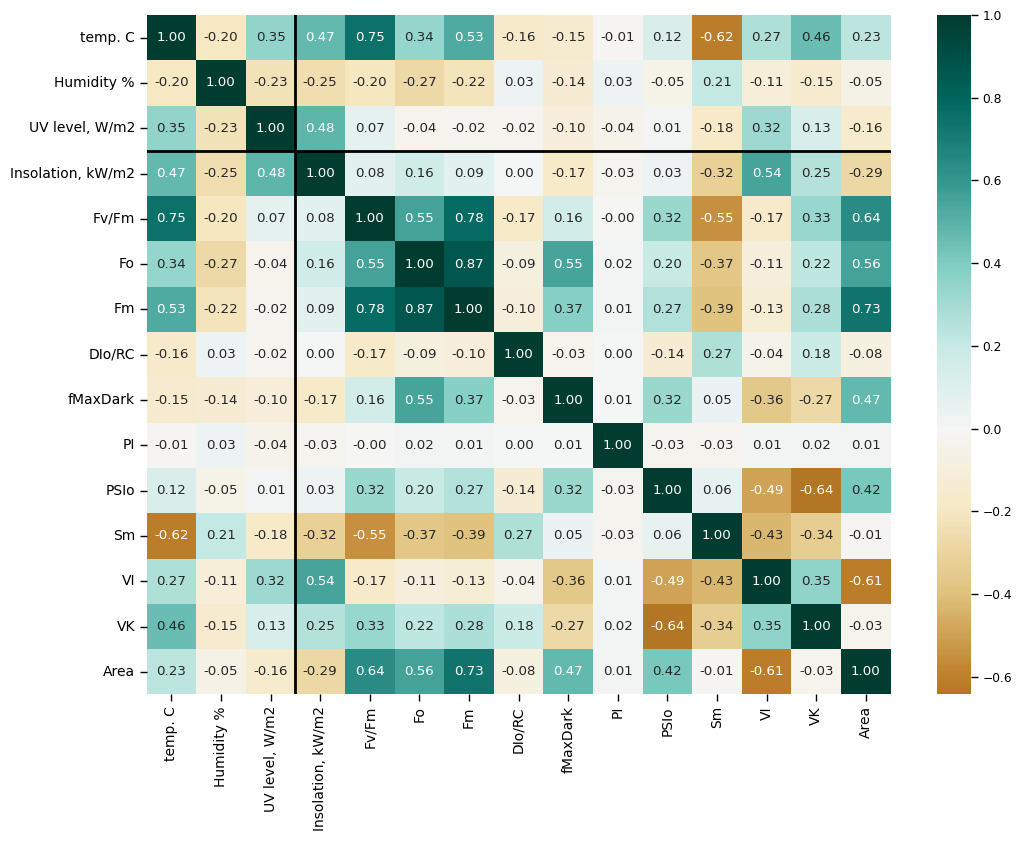

In [10]:
plt.figure()
plot_corrmatr(df_3h_filtered)
plt.axhline(y=3, linewidth=2, color='black')
plt.axvline(x=3, linewidth=2, color='black')
plt.savefig(os.path.join(savepath, 'corr_global.png'))

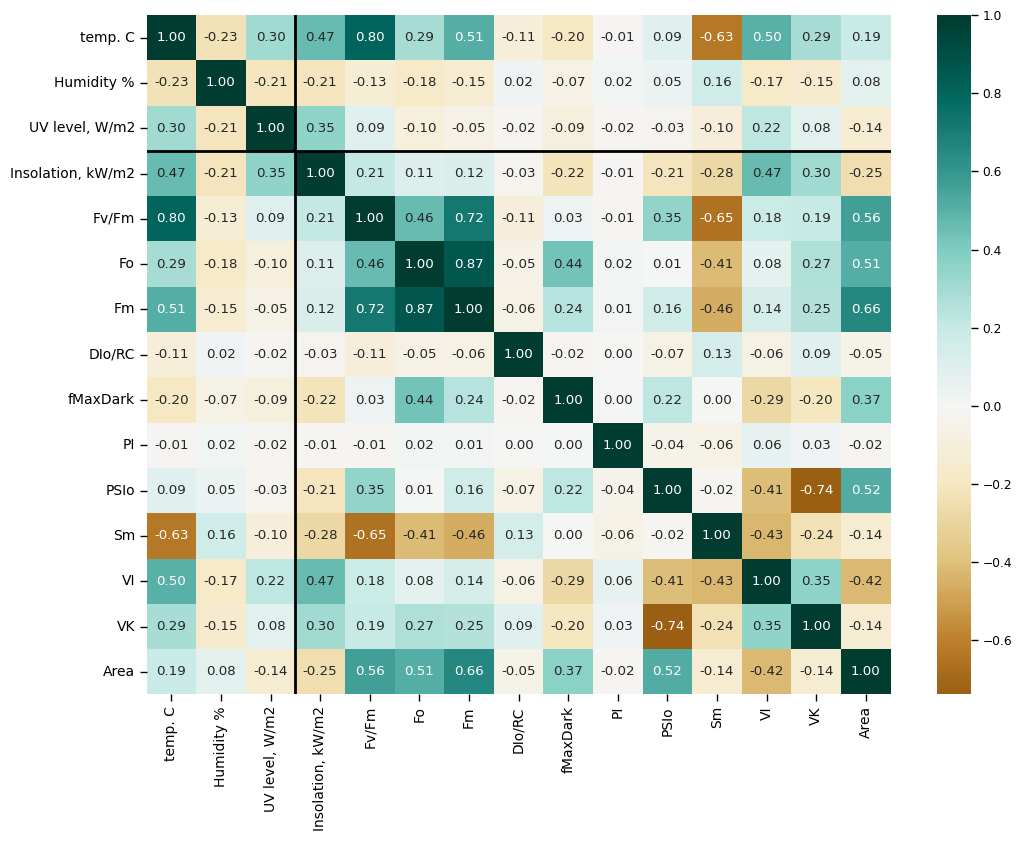

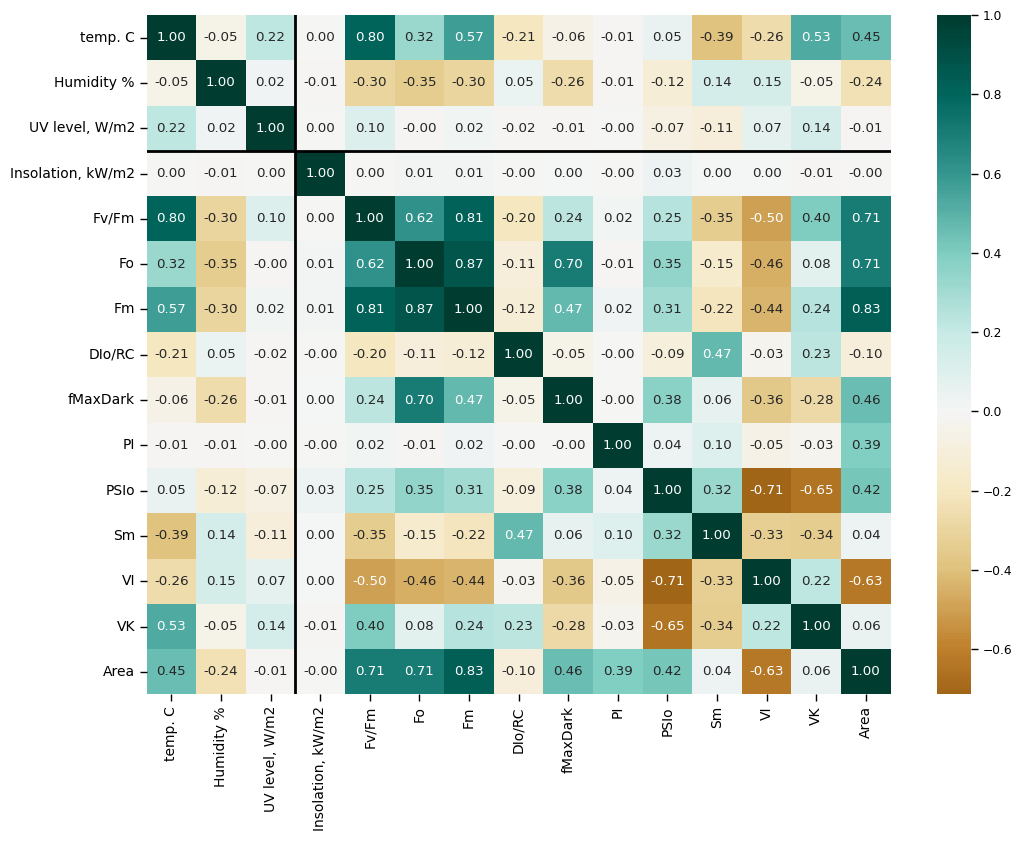

In [11]:
day = ds[ds['Insolation, kW/m2'] > 0.00002]
night = ds[ds['Insolation, kW/m2'] < 0.00002]
plt.figure()
plot_corrmatr(day)
plt.axhline(y=3, linewidth=2, color='black')
plt.axvline(x=3, linewidth=2, color='black')
plt.savefig(os.path.join(savepath, 'corr_day_only.png'))
plt.figure()
plot_corrmatr(night)
plt.axhline(y=3, linewidth=2, color='black')
plt.axvline(x=3, linewidth=2, color='black')
plt.savefig(os.path.join(savepath, 'corr_night_only.png'))

Let's compare moving average filter performance with our lowpass implementation

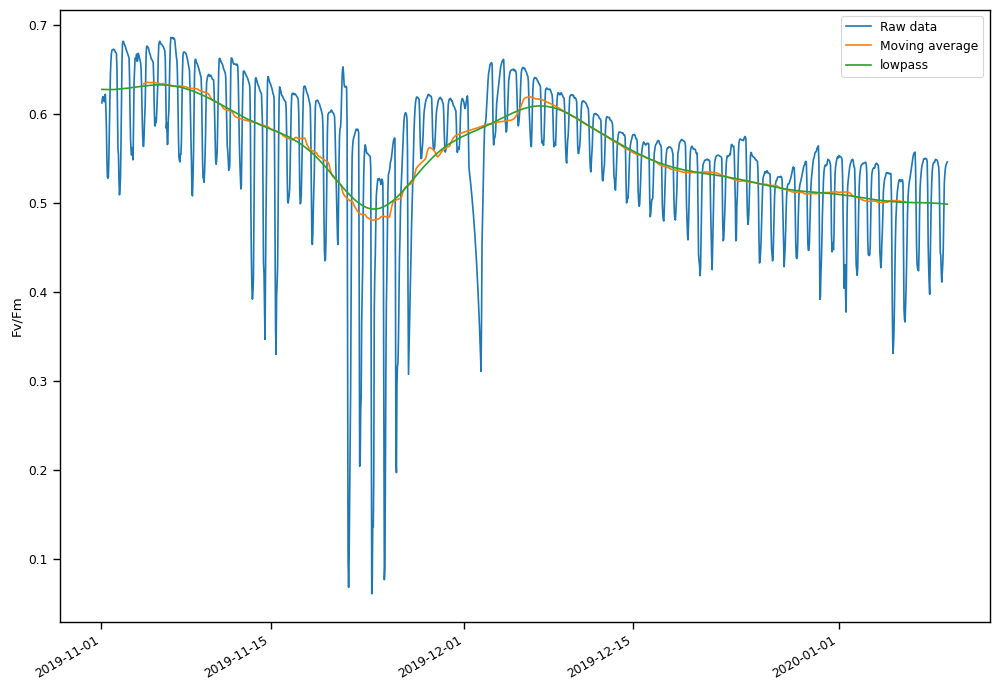

In [12]:
week_filtered, taps = lowpass_filter(df['Fv/Fm'], 168.)
df['Fv/Fm'][datetime(2019, 11, 1):datetime(2020, 1, 10)].plot(label='Raw data')
plt.plot(df[datetime(2019, 11, 1):datetime(2020, 1, 10)].index - pd.Timedelta(hours=84), df['Fv/Fm'][datetime(2019, 11, 1):datetime(2020, 1, 10)].rolling(window=168).mean(), label='Moving average')
week_filtered[datetime(2019, 11, 1):datetime(2020, 1, 10)].plot(label='lowpass')
plt.ylabel('Fv/Fm')
plt.legend()

Looks like the moving average is more sensitive, but also more noisy. Overall the FIR performance is good here. Let's plot the filter frequency response

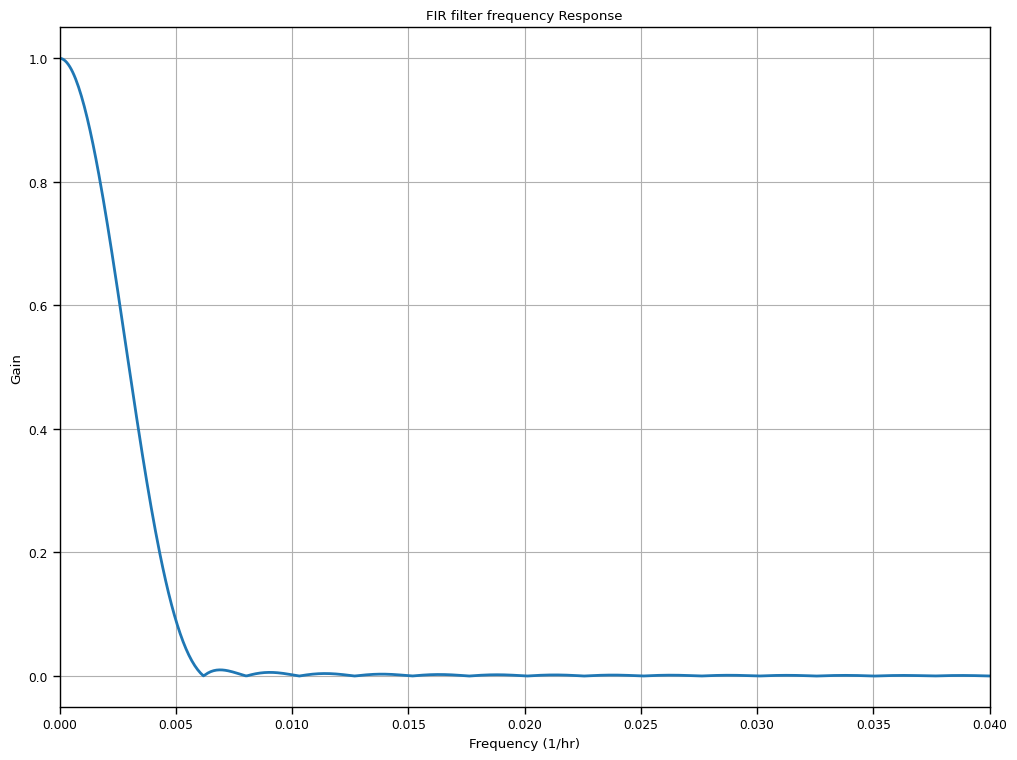

In [13]:
w, h = freqz(taps, worN=8000)
plt.plot((w/np.pi)/2, np.abs(h), linewidth=2)
plt.xlabel('Frequency (1/hr)')
plt.ylabel('Gain')
plt.title('FIR filter frequency Response')
plt.ylim(-0.05, 1.05)
plt.xlim(0, 0.04)
plt.grid(True)

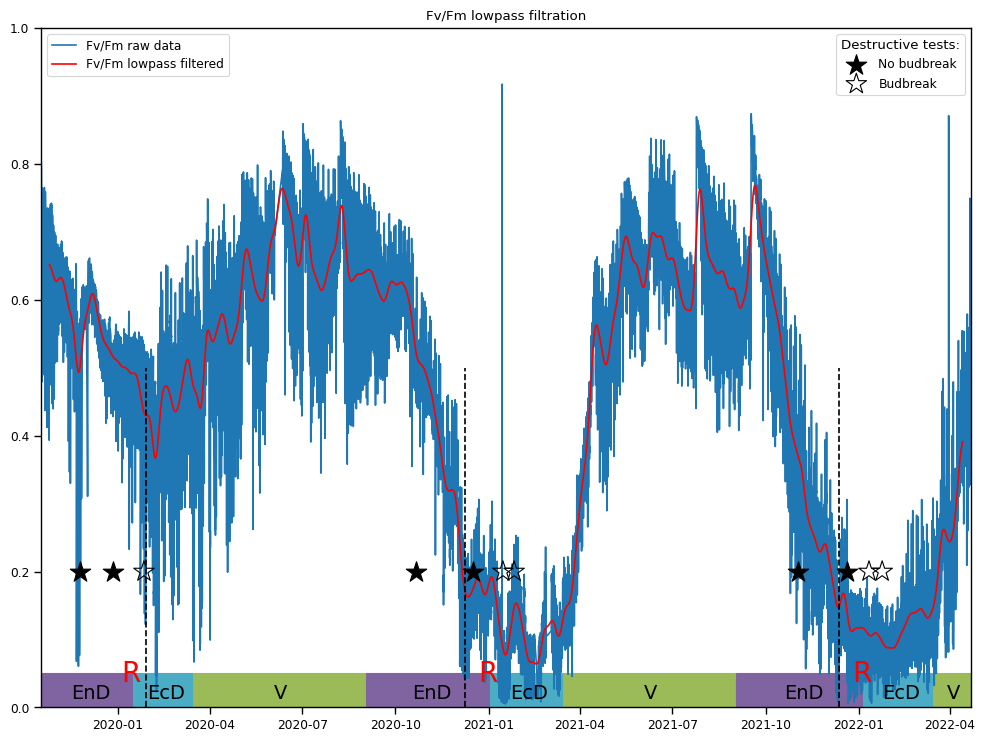

In [14]:
plt.plot(df['Fv/Fm'], label='Fv/Fm raw data')
plt.plot(df_1w_filtered['Fv/Fm'], c='r', label='Fv/Fm lowpass filtered')
plt.title('Fv/Fm lowpass filtration')
legend_old = plt.legend(loc='upper left')
plt.xlim(df.index[0], df.index[-1])
plt.ylim(0, 1)
annotate_gt(0.05, -0.05, 0.2)
plt.gca().add_artist(legend_old)
plt.savefig(os.path.join(savepath, 'FvFm lowpass.png'))

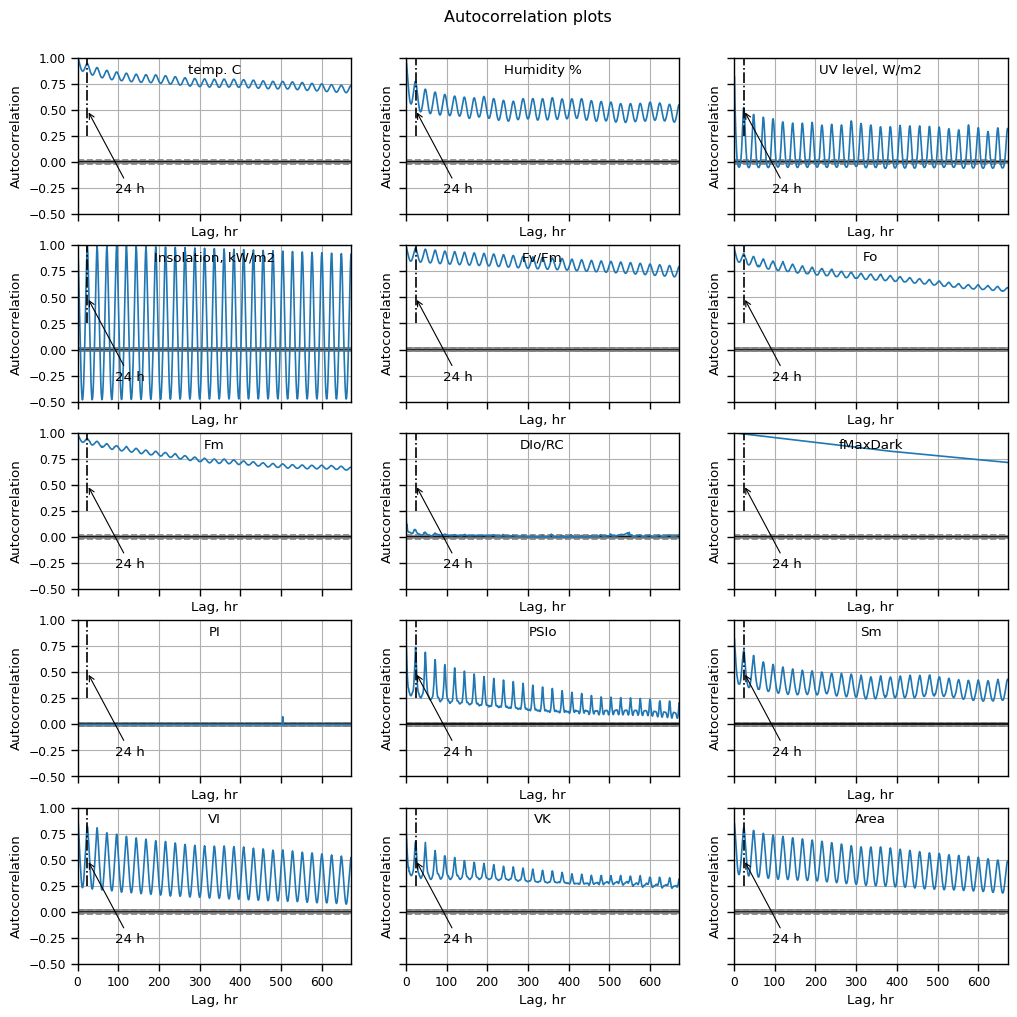

In [15]:
fig, axs = plt.subplots(5, 3, sharex=True, sharey=True, figsize=(12, 12))
for i, col in enumerate(ds.columns):
    ax = axs[i // 3][i % 3]
    pd.plotting.autocorrelation_plot(ds[col].resample("1H").median().dropna(), ax=ax)
    ax.text(.5, .9, f'{col}',
        horizontalalignment='center',
        transform=ax.transAxes)
    ax.set_xlabel('Lag, hr')
fig.suptitle('Autocorrelation plots', y=0.92)
plt.savefig(os.path.join(savepath, 'autocorr-full.png'))
ax.set_xlim(0, 672)
for i, col in enumerate(ds.columns):
    ax = axs[i // 3][i % 3]
    ax.plot([24, 24], [0.25, 1], 'k-.')
    ax.set_ylim(-0.5, 1)
    ax.annotate('24 h', xy=(24, 0.5), xycoords='data',
                 xytext=(20, -60), textcoords='offset points',
                 arrowprops=dict(arrowstyle="->"))
plt.savefig(os.path.join(savepath, 'autocorr-1month.png'))


Fv/Fm is highly periodic and follows temperature quite closely. This is not the case for DIo/RC or PI.

<ipython-input-3-d040879b9f21>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks())
<ipython-input-3-d040879b9f21>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{tick:%d.%m.%Y}' for tick in newticks])


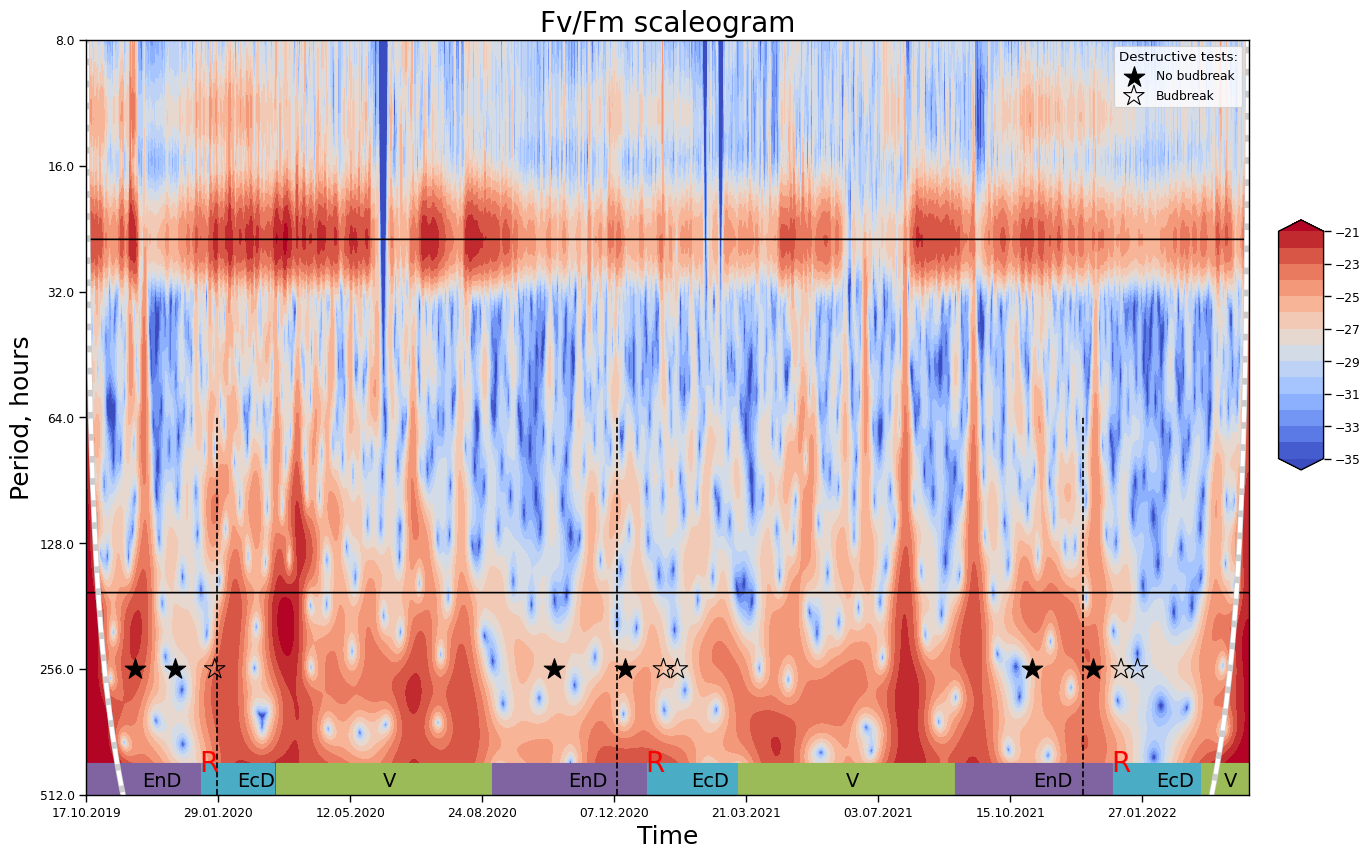

In [16]:
ax = plot_wavelet(df['t-t0, hr'], df['Fv/Fm'], contourlevels=np.arange(-35, -20))
xmin, xmax = ax.get_xlim()
factor = (xmax - xmin) / (mdates.date2num(df.index[-1]) - mdates.date2num(df.index[0]))
annotate_gt(8.75, 0.25, 8, axes=ax, custom_xscale={'min': mdates.date2num(df.index[0]), 'factor': factor})
plt.savefig(os.path.join(savepath, 'FvFm wavelet annotated.png'))

<ipython-input-3-d040879b9f21>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks())
<ipython-input-3-d040879b9f21>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{tick:%d.%m.%Y}' for tick in newticks])


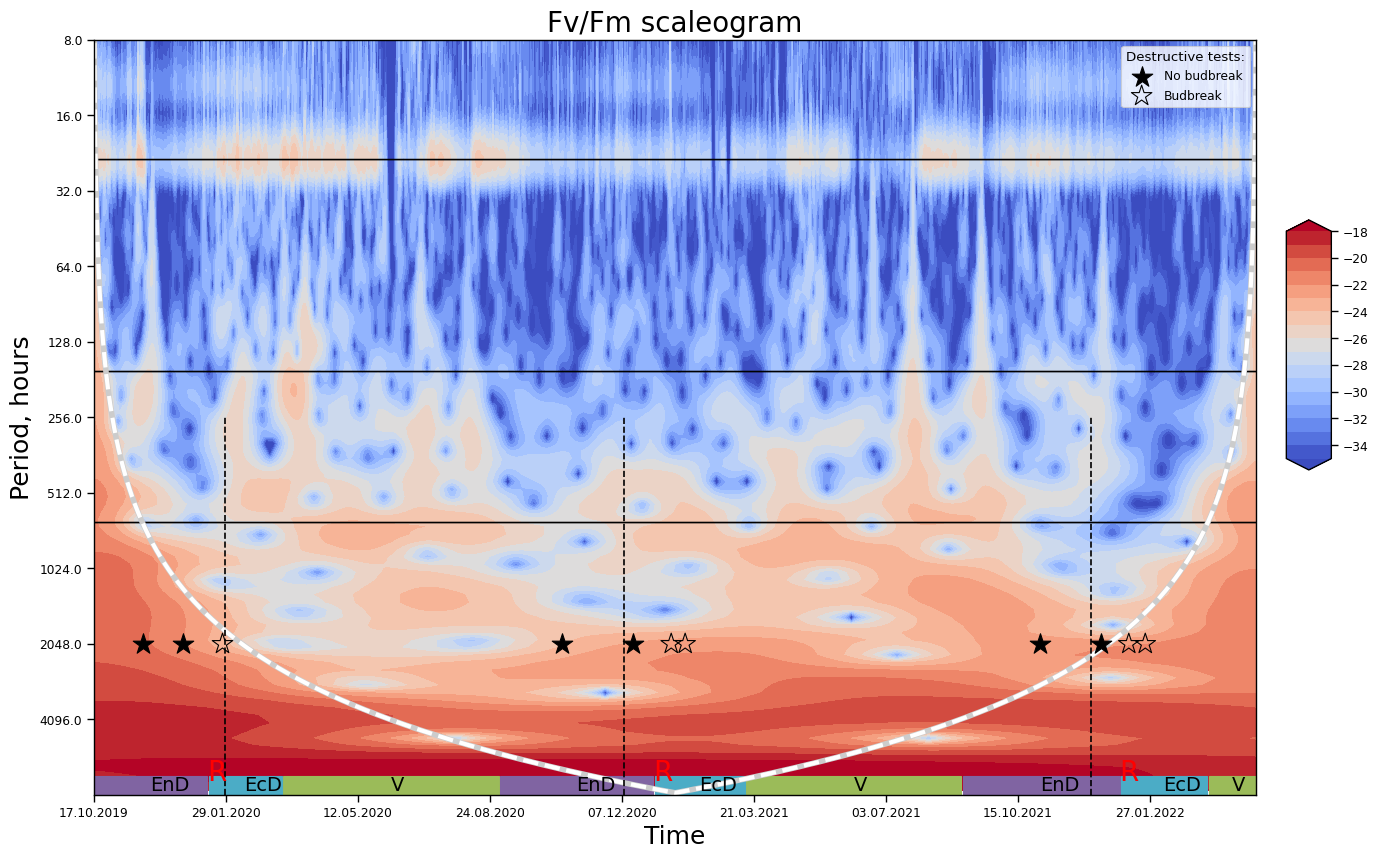

In [17]:
ax = plot_wavelet(df['t-t0, hr'], df['Fv/Fm'], scales=np.power(2.0, np.arange(0, 13, 0.1)), fixed_ylim=(13, 3), contourlevels=np.arange(-35, -17))
annotate_gt(12.75, 0.25, 11, axes=ax, custom_xscale={'min': mdates.date2num(df.index[0]), 'factor': factor})
plt.savefig(os.path.join(savepath, 'FvFm wavelet annotated-bigpicture.png'))

<ipython-input-3-d040879b9f21>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks())
<ipython-input-3-d040879b9f21>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{tick:%d.%m.%Y}' for tick in newticks])


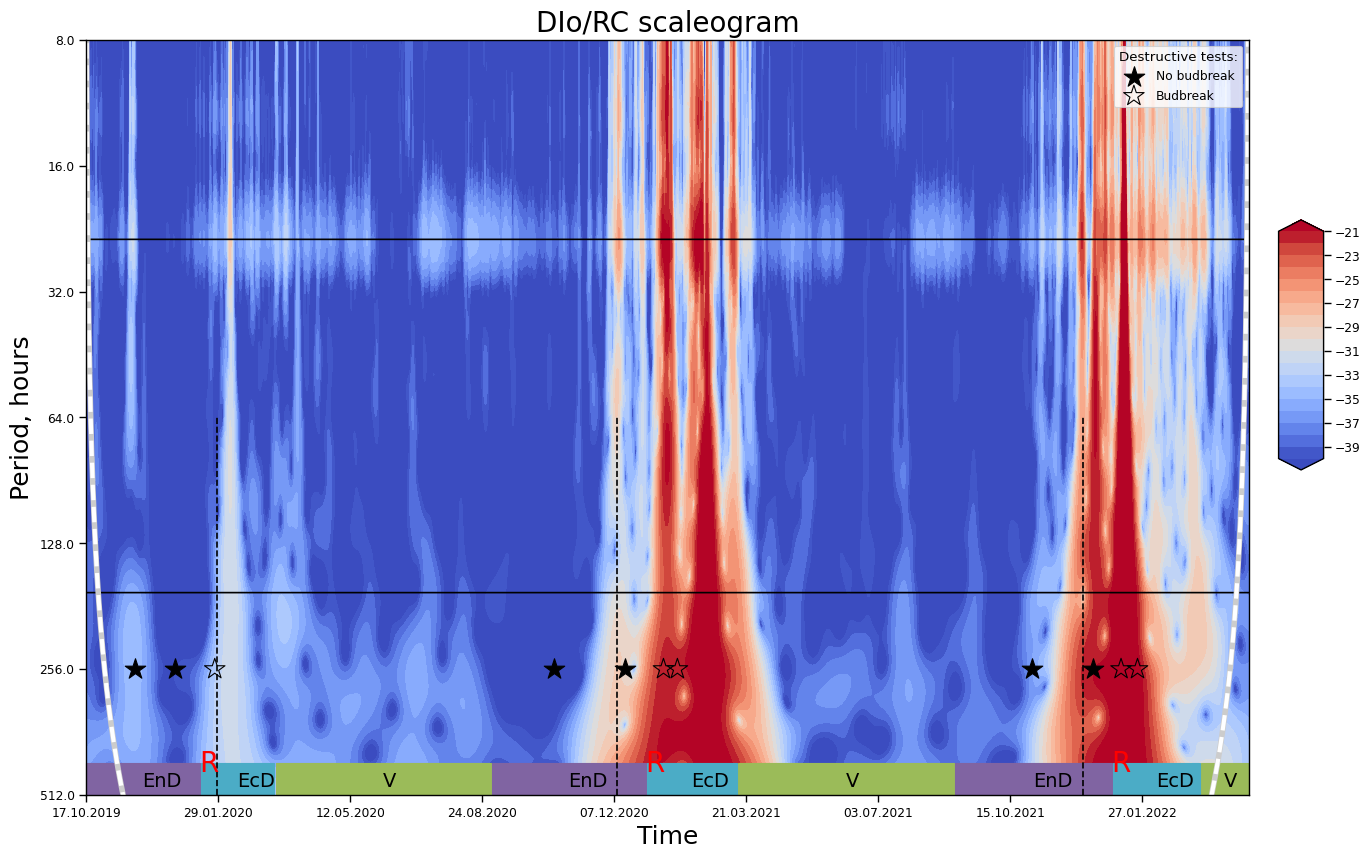

In [18]:
ax = plot_wavelet(df['t-t0, hr'], df['DIo/RC'], np.arange(1, 512), contourlevels=np.arange(-40, -20))
xmin, xmax = ax.get_xlim()
factor = (xmax - xmin) / (mdates.date2num(df.index[-1]) - mdates.date2num(df.index[0]))
annotate_gt(8.75, 0.25, 8, axes=ax, custom_xscale={'min': mdates.date2num(df.index[0]), 
                                                   'factor': factor})
plt.savefig(os.path.join(savepath, 'DIoRC wavelet annotated.png'))

A satisfying spectrogram: spectral power after lowpass filtration

<ipython-input-3-d040879b9f21>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks())
<ipython-input-3-d040879b9f21>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{tick:%d.%m.%Y}' for tick in newticks])


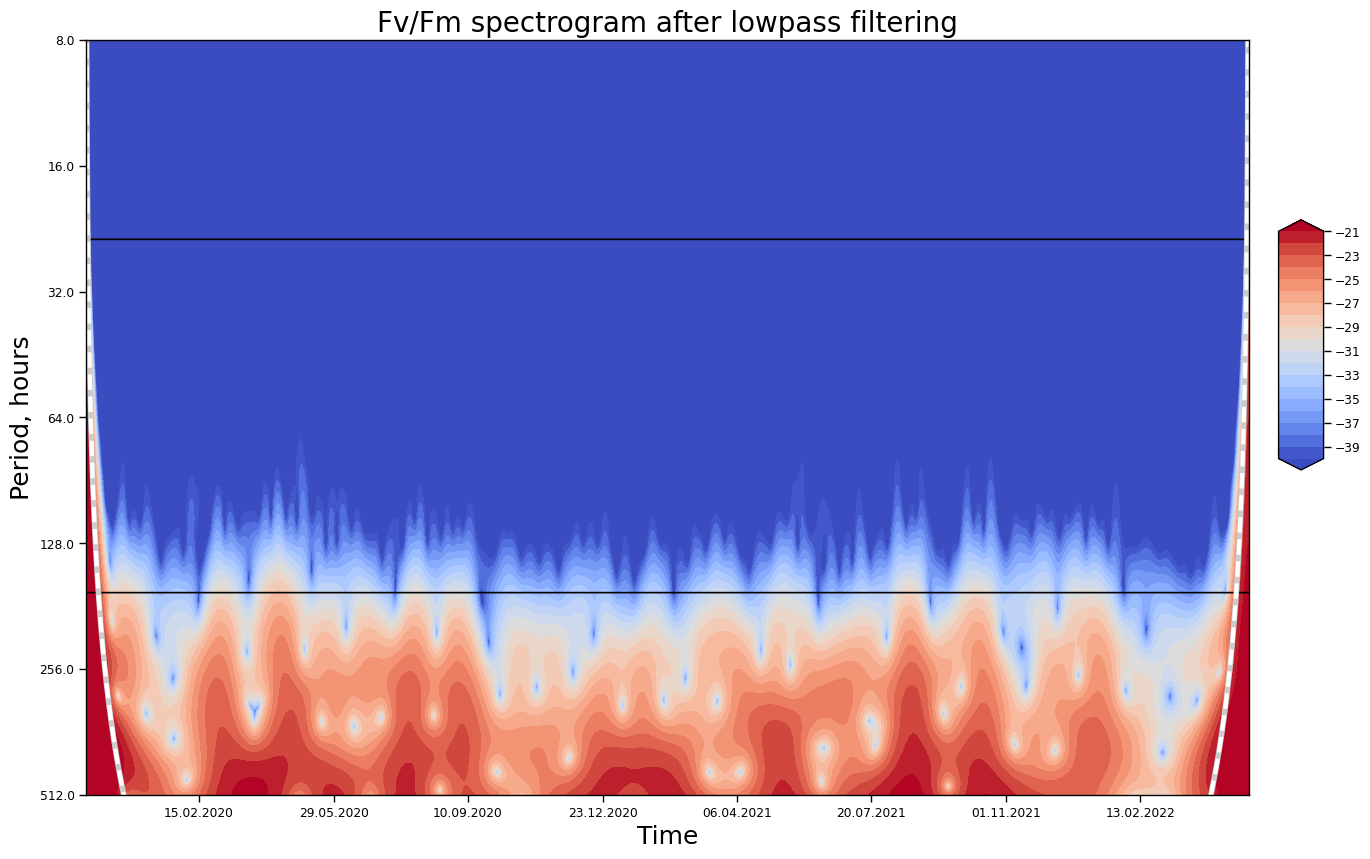

In [19]:
N = 400 # kaiserord(42db, 2/168 cutoff)
ax_wl = plot_wavelet(df['t-t0, hr'][N-1:], pd.Series(lfilter(taps, 1.0, df['Fv/Fm'].values)[N-1:], index=df.index[N-1:]), np.arange(1, 512), title='Fv/Fm spectrogram after lowpass filtering')

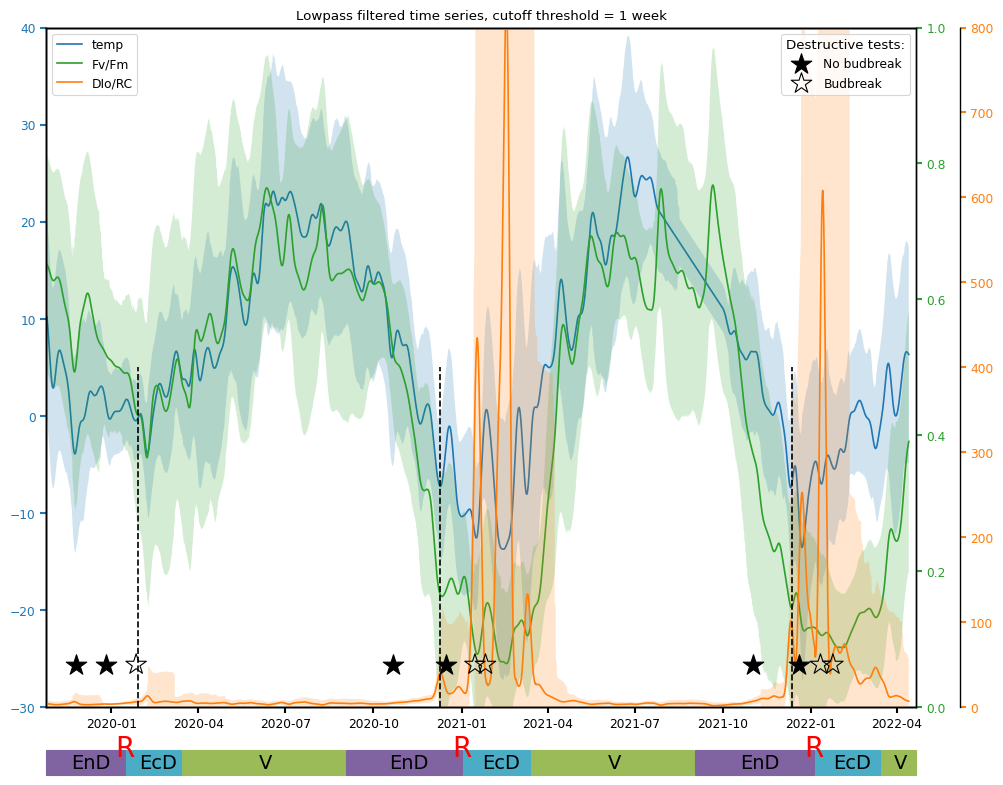

In [20]:
fig, ax = plt.subplots()
twin1 = ax.twinx()
twin2 = ax.twinx()
fig.subplots_adjust(right=0.85)
twin2.spines.right.set_position(("axes", 1.05))
temp = lowpass_filter(ds['temp. C'], 168.)[0]
filtered_index = temp.index
p1, = ax.plot(filtered_index, temp, label='temp', color='tab:blue')
temp_std = ds['temp. C'].rolling(168*4).std()[200:].bfill()
# hatch='//'
ax.fill_between(temp_std.index, temp - 2 * temp_std, temp + 2 * temp_std, facecolor='tab:blue', alpha=0.2)

fvfm = lowpass_filter(ds['Fv/Fm'], 168.)[0]
p2, = twin1.plot(filtered_index, fvfm, label='Fv/Fm', color='tab:green')
fvfm_std = ds['Fv/Fm'].rolling(168*4).std()[200:].bfill()
twin1.fill_between(ds.index[200:], fvfm - 2 * fvfm_std, fvfm + 2 * fvfm_std, facecolor='tab:green', alpha=0.2)

dio_rc = lowpass_filter(ds['DIo/RC'], 168.)[0]
p3, = twin2.plot(filtered_index, dio_rc, label='DIo/RC', color='tab:orange')
dio_std = ds['DIo/RC'].rolling(168*4).std()[200:].bfill()
twin2.fill_between(dio_std.index, dio_rc - 2 * dio_std, dio_rc + 2 * dio_std, facecolor='tab:orange', alpha=0.2)

ax.set_xlim(datetime(2019, 10, 25), datetime(2022, 4, 21))
twin1.set_xlim(datetime(2019, 10, 25), datetime(2022, 4, 21))
twin2.set_xlim(datetime(2019, 10, 25), datetime(2022, 4, 21))

ax.set_ylim(-30, 40)
twin1.set_ylim(0, 1)
twin2.set_ylim(0, 800)
ax.yaxis.label.set_color('tab:blue')
twin1.yaxis.label.set_color('tab:green')
twin2.yaxis.label.set_color('tab:orange')
tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
twin2.tick_params(axis='y', colors=p3.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)
ax.legend(handles=[p1, p2, p3], loc='upper left')
ax.set_title('Lowpass filtered time series, cutoff threshold = 1 week')
annotate_gt(-50, -30, 50, axes=twin2)
fig.savefig(os.path.join(savepath, 'lowpass-overlay-3curves.png'))